In [91]:
from glob import glob

import mahotas as mh
from mahotas.features import surf

from sklearn import model_selection
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans

from scipy.spatial import distance

import numpy as np
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [13]:
def disp(img, name = ''):
    plt.figure(figsize = (10, 10))
    plt.imshow(img)
    if len(img.shape) < 3:
        plt.gray()
    plt.axis('off')
    plt.title(name)
    plt.show()

In [5]:
img = mh.imread('scene00.jpg')

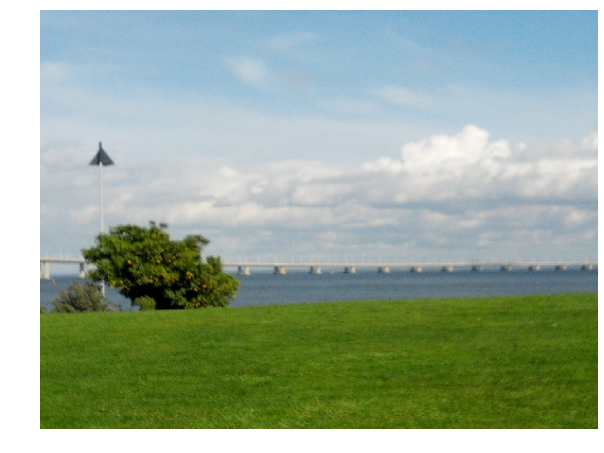

In [14]:
disp(img)

Бинаризация

In [11]:
img_g = mh.colors.rgb2grey(img, dtype = np.uint8)

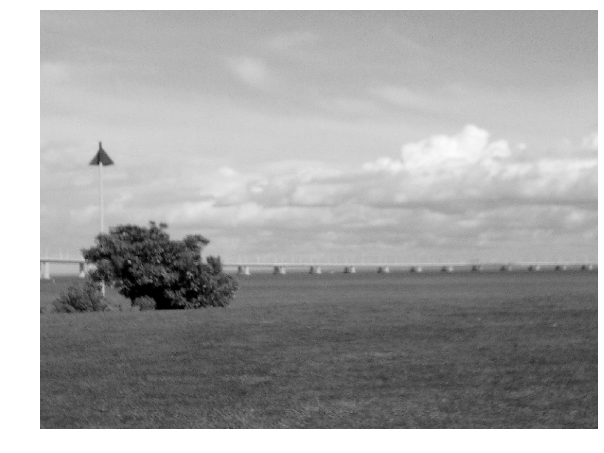

In [15]:
disp(img_g)

Otsu threshold == 138


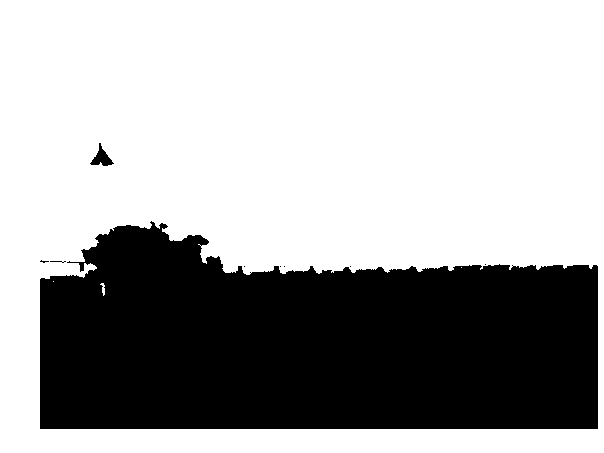

In [23]:
thresh = mh.thresholding.otsu(img_g)
print(f'Otsu threshold == {thresh}')
disp(img_g > thresh)

Гауссово размытие

In [26]:
im16 = mh.gaussian_filter(img_g, 16)

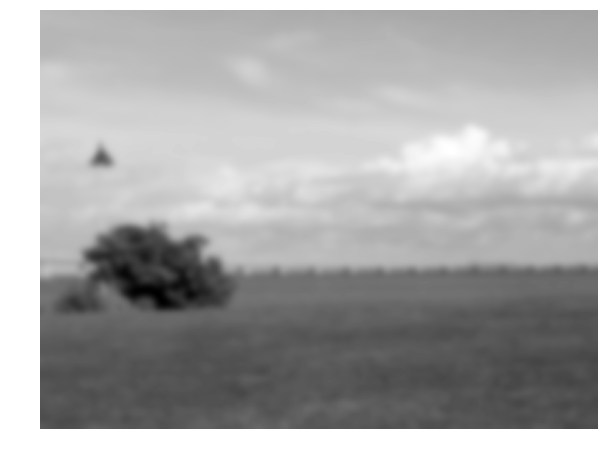

In [27]:
disp(im16)

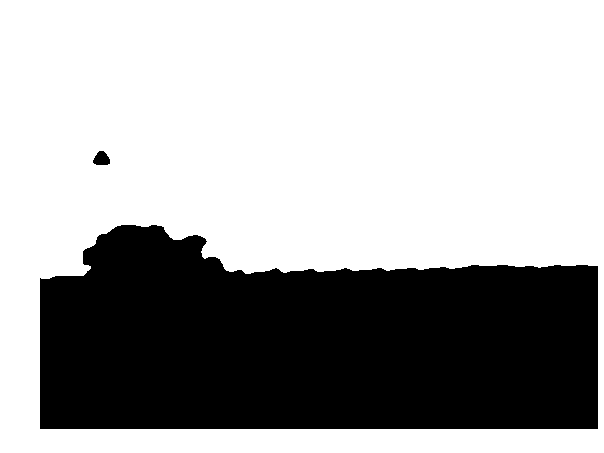

In [30]:
disp(im16 > thresh)

Помещение центра в фокус

In [31]:
img = mh.demos.load('lena')

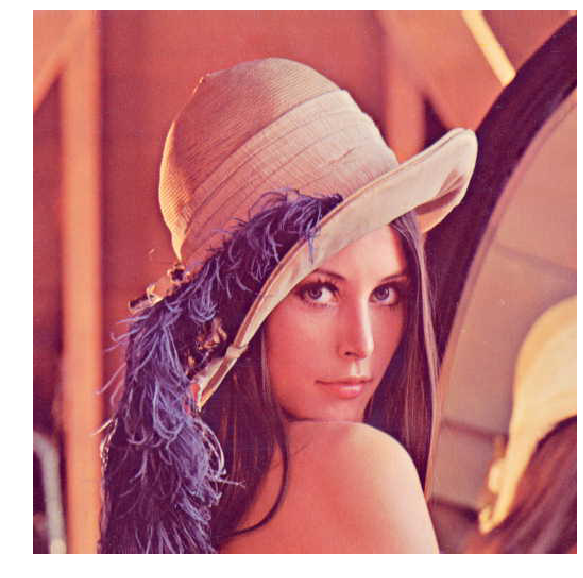

In [32]:
disp(img)

In [33]:
r, g, b = img.transpose(2, 0, 1)
r12 = mh.gaussian_filter(r, 12.)
g12 = mh.gaussian_filter(g, 12.)
b12 = mh.gaussian_filter(b, 12.)
img12 = mh.as_rgb(r12, g12, b12)

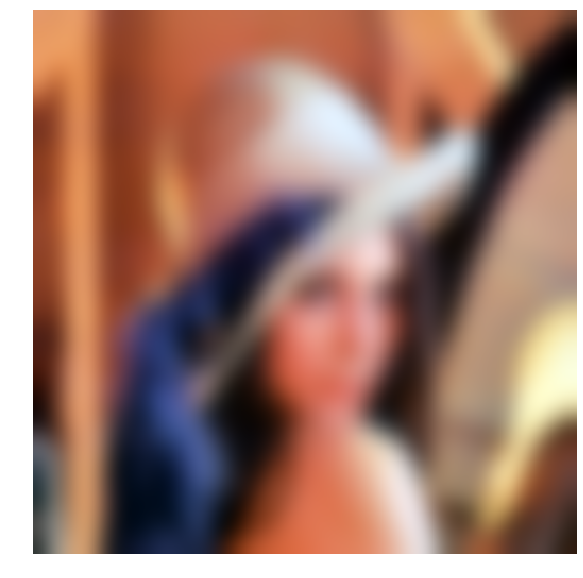

In [34]:
disp(img12)

In [36]:
h, w = r.shape
Y, X = np.mgrid[:h, :w]

Y = Y - h / 2
Y = Y / Y.max()

X = X - w / 2
X = X / X.max()

C = np.exp(-2. * (X ** 2 + Y ** 2))
C = C - C.min()
C = C / C.ptp()
C = C[:, :, None]

ringed = mh.stretch(img * C + (1 - C) * img12)

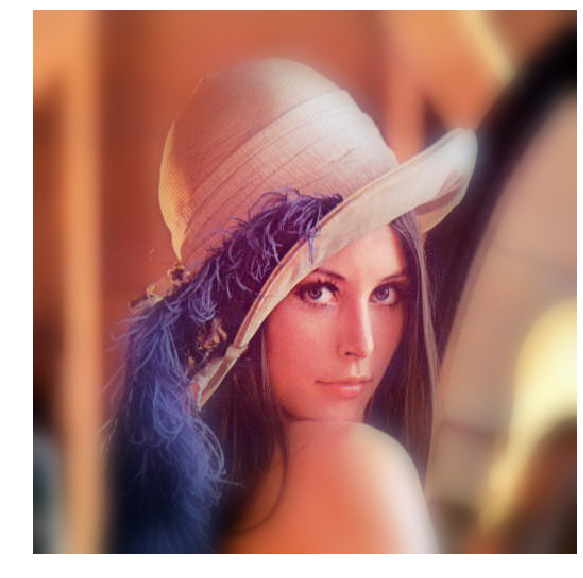

In [37]:
disp(ringed)

Вычисление признаков по изображению

In [65]:
imgs = glob('SimpleImageDataset/*.jpg')
features = []
labels = []
for img in imgs:
    labels.append(img[:-len('00.jpg')])
    img = mh.imread(img)
    img = mh.colors.rgb2gray(img, dtype = np.uint8)
    features.append(mh.features.haralick(img).ravel())
features = np.array(features)
labels = np.array(labels)

In [66]:
clf = Pipeline([('preproc', StandardScaler()), ('classifier', LogisticRegression())])
loo = model_selection.LeaveOneOut().get_n_splits((len(imgs), len(imgs)))
scores = model_selection.cross_val_score(clf, features, labels, cv = loo)
print('Точность: {:.1%}'.format(scores.mean()))

Точность: 72.2%


Создание собственных признаков

In [57]:
def chist(img: np.ndarray):
    img = img // 64
    r, g, b = img.transpose((2, 0, 1))
    pixels = r + 4 * b + 16 * g
    hist = np.bincount(pixels.ravel(), minlength = 64)
    return np.log1p(hist.astype(float))

In [61]:
features = []
labels = []
for img in imgs:
    labels.append(img[:-len('00.jpg')])
    img = mh.imread(img)
    img_g = mh.colors.rgb2gray(img, dtype = np.uint8)
    features.append(np.concatenate([mh.features.haralick(img_g).ravel(), chist(img)]))
features = np.array(features)
labels = np.array(labels)

In [64]:
clf = Pipeline([('preproc', StandardScaler()), ('classifier', LogisticRegression())])
loo = model_selection.LeaveOneOut().get_n_splits((len(imgs), len(imgs)))
scores = model_selection.cross_val_score(clf, features, labels, cv = loo)
print('Точность: {:.1%}'.format(scores.mean()))

Точность: 82.2%


Использование признаков для поиска похожих изображений

In [70]:
features = []
for img in imgs:
    img = mh.imread(img)
    img = img[200 : -200, 200 : -200]
    img_g = mh.colors.rgb2gray(img, dtype = np.uint8)
    features.append(np.concatenate([mh.features.haralick(img_g).ravel(), chist(img)]))
features = np.array(features)
sc = StandardScaler()
features = sc.fit_transform(features)
dists = distance.squareform(distance.pdist(features))

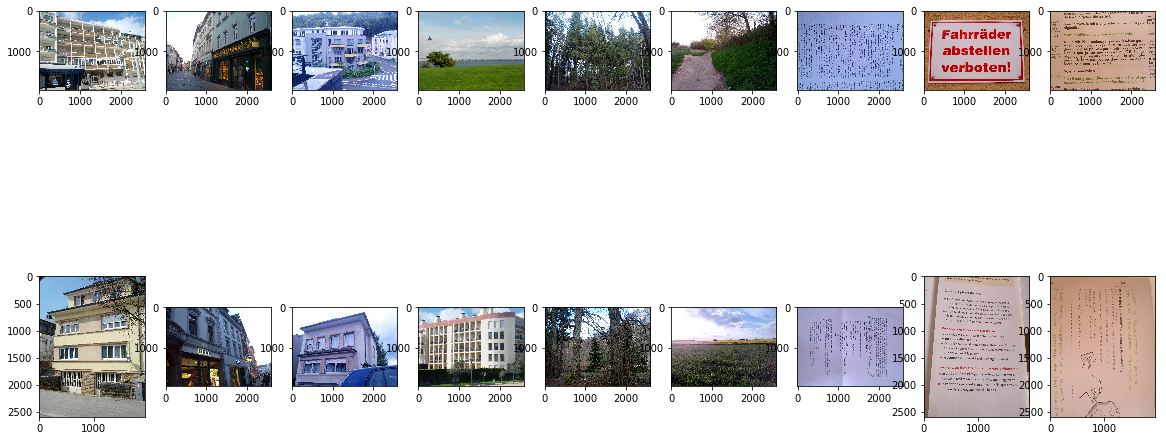

In [85]:
fig, ax = plt.subplots(2, 9, figsize = (20, 10))
for ci, i in enumerate(range(0, 90, 10)):
    left = imgs[i]
    dists_left = dists[i]
    right = dists_left.argsort()
    right = imgs[right[1]]
    left = mh.imread(left)
    right = mh.imread(right)
    ax[0, ci].imshow(left)
    ax[1, ci].imshow(right)

Классификация на более трудном наборе данных

In [88]:
C_range = 10. ** np.arange(-4, 3)
grid = model_selection.GridSearchCV(LogisticRegression(), param_grid = {'C': C_range})
clf = Pipeline([('preproc', StandardScaler()), ('classifier', grid)])
kf = model_selection.KFold(5, shuffle = True, random_state = 123).get_n_splits(len(features))
scores = model_selection.cross_val_score(clf, features, labels, cv = kf)
print('Точность: {:.1%}'.format(scores.mean()))

Точность: 91.1%


Локальные представления признаков

In [90]:
descs = []
for img in imgs:
    img = mh.imread(img, as_grey = True).astype(np.uint8)
    descs.append(surf.dense(img, spacing = 16))
conc = np.concatenate(descs)
print(f'{len(conc)} дескрипторов')

1580040 дескрипторов


In [92]:
conc = conc[::64]
k = 256
km = KMeans(k)
km.fit(conc)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=256, n_init=10, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [94]:
sfeatures = []
for d in descs:
    c = km.predict(d)
    sfeatures.append(np.array([np.sum(c == ci) for ci in range(k)]))
sfeatures = np.array(sfeatures, dtype = float)
scores = model_selection.cross_val_score(clf, sfeatures, labels, cv = kf)
print('Точность: {:.1%}'.format(scores.mean()))

Точность: 94.4%


In [95]:
features_combined = np.hstack([features, sfeatures])
scores = model_selection.cross_val_score(clf, features_combined, labels, cv = kf)
print('Точность: {:.1%}'.format(scores.mean()))

Точность: 96.7%
